# Load forecasting inference notebook.

In [1]:
import joblib
import requests
import zipfile
import pandas as pd
#import seaborn as sns
from glob import glob
from dateutil.relativedelta import relativedelta
import datetime
import os
from io import StringIO
import numpy as np

%matplotlib inline

### Load weather data filtered on the unnecessary features and only with NYC grid WBANS.

In [2]:
# Unnecesary if we're loading the load_and_weather_data_final dataframe.
weather_features_hourly = joblib.load('/volumes/data/notebook2/weather_features_hourly')

### Load NYC grid load data

In [3]:
load_data = joblib.load('/volumes/data/notebook2/county_load_df_rolling')

### Combine the Load and Weather data for the testing period.

In [4]:
def combine_load_weather_df(county_load_df_rolling, weather_features_hourly, save=None):
    """
    Combine the load dataframe and the weather dataframes into a single dataframe.

    Args:
        county_load_df_rolling: Dataframe: Load data for the specific county, 
            filtered and cleaned.
        weather_features_hourly: Dataframe: Weather data.

    Returns:
        load_and_weather_data_final: Dataframe: Combined dataframe containing
            both weather and load features for the same timestamps.
    """

    del weather_features_hourly.columns.name
    del weather_features_hourly.index.name

    load_and_weather_data = pd.merge(
        weather_features_hourly,
        county_load_df_rolling['Load'],
        how='outer',
        left_index=True,
        right_index=True)

    load_and_weather_data.columns = ['temperature', 'dewpoint', 'load']

    # interpolate any missing values linearly.
    load_and_weather_data = load_and_weather_data.interpolate(
            method='linear', axis=0).ffill().bfill()

    # Build date and time features.
    load_and_weather_data['year'] = load_and_weather_data.index.map(lambda x: x.year)
    load_and_weather_data['month'] = load_and_weather_data.index.map(lambda x: x.month)
    load_and_weather_data['day'] = load_and_weather_data.index.map(lambda x: x.day)
    load_and_weather_data['weekday'] = load_and_weather_data.index.map(lambda x: x.weekday)
    load_and_weather_data['hour'] = load_and_weather_data.index.map(lambda x: x.hour)

    # Build lagged weather predictors.
    for ix in range(8):
        load_and_weather_data['temperature_d' + str(ix)] = load_and_weather_data['temperature'].shift(24*ix)
        load_and_weather_data['dewpoint_d' + str(ix)] = load_and_weather_data['dewpoint'].shift(24*ix)

    # Next day's load values.
    load_and_weather_data['load_tomorrow'] = load_and_weather_data['load'].shift(-24)

    load_and_weather_data = load_and_weather_data.fillna(0)

    if save:
        joblib.dump(load_and_weather_data, os.path.join(save, 'load_and_weather_data'))

    return load_and_weather_data

load_and_weather_data_all = combine_load_weather_df(
    load_data, 
    weather_features_hourly, save=None)

#load_and_weather_data = joblib.load('/volumes/data/notebook2/load_and_weather_data')

#load_and_weather_data = load_and_weather_data['2017-01-01':'2017-02-28']

In [5]:
load_and_weather_data_all.head()

,temperature,dewpoint,load,year,month,day,weekday,hour,temperature_d0,dewpoint_d0,...,dewpoint_d3,temperature_d4,dewpoint_d4,temperature_d5,dewpoint_d5,temperature_d6,dewpoint_d6,temperature_d7,dewpoint_d7,load_tomorrow
2010-01-01 00:00:00,0.883333,-0.20,5395.791667,2010,1,1,4,0,0.883333,-0.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5151.941667
2010-01-01 01:00:00,0.986667,0.04,5192.575000,2010,1,1,4,1,0.986667,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4907.616667
2010-01-01 02:00:00,0.986667,0.44,4978.225000,2010,1,1,4,2,0.986667,0.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4758.416667
2010-01-01 03:00:00,0.883333,0.60,4784.608333,2010,1,1,4,3,0.883333,0.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4646.358333
2010-01-01 04:00:00,0.883333,0.50,4696.741667,2010,1,1,4,4,0.883333,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4612.775000


### Define features to use for training.

In [6]:
print(load_and_weather_data_all.columns)
print(len(load_and_weather_data_all.columns))

Index(['temperature', 'dewpoint', 'load', 'year', 'month', 'day', 'weekday',
       'hour', 'temperature_d0', 'dewpoint_d0', 'temperature_d1',
       'dewpoint_d1', 'temperature_d2', 'dewpoint_d2', 'temperature_d3',
       'dewpoint_d3', 'temperature_d4', 'dewpoint_d4', 'temperature_d5',
       'dewpoint_d5', 'temperature_d6', 'dewpoint_d6', 'temperature_d7',
       'dewpoint_d7', 'load_tomorrow'],
      dtype='object')
25


In [7]:
features_to_normalize = [
#    'load',
    'temperature_d0', 'dewpoint_d0',
    'temperature_d1', 'dewpoint_d1',
    'temperature_d2', 'dewpoint_d2',
    'temperature_d3', 'dewpoint_d3',
    'temperature_d4', 'dewpoint_d4',
    'temperature_d5', 'dewpoint_d5',
    'temperature_d6', 'dewpoint_d6',
    'temperature_d7', 'dewpoint_d7']

as_is_features = [feature 
              for feature in load_and_weather_data_all.columns 
              if feature not in features_to_normalize]

scaler_dict = joblib.load('/volumes/data/notebook2/scaler_dict')

def normalize_features_with_scalers(test_df, features_to_normalize, as_is_features, scaler_dict):
    """
    Normalize the features of the dataframe using the dictionary of StandardScalers 
    mapping the column name of the features to be normalized to their previously fit
    StandardScalers.

    Args:
        test_df: Dataframe: Dataframe that needs to be standardized.
        features_to_normalize: List: list of features that need to be standardized.
        as_is_features: List of features to keep as they are.
        scaler_dict: Dict: The dictionary that maps indivisual feature names to their 
            previously fitted StandardScalers.

    Returns:
        normalized_df: Dataframe: Dataframe where the features have been normalized.
    """
    norm_features_df = test_df[features_to_normalize]

    for norm_feature in features_to_normalize:
        norm_features_df[norm_feature] = scaler_dict[norm_feature].transform(
            norm_features_df[norm_feature].values.reshape(-1,1))

    std_df = pd.concat(
        [test_df[as_is_features], norm_features_df], axis=1)

    return std_df

load_and_weather_data_all = normalize_features_with_scalers(
    load_and_weather_data_all, features_to_normalize, as_is_features, scaler_dict)

load_and_weather_data_all_final = pd.get_dummies(
    load_and_weather_data_all, columns=['month', 'weekday', 'day'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
load_and_weather_data_test = load_and_weather_data_all_final['2017-01-01':'2017-02-28']

In [9]:
load_and_weather_data_test

,temperature,dewpoint,load,year,hour,load_tomorrow,temperature_d0,dewpoint_d0,temperature_d1,dewpoint_d1,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
2017-01-01 00:00:00,7.066667,-3.533333,5031.266667,2017,0,4799.975000,-0.638744,-0.841570,-1.244215,-1.277277,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 01:00:00,7.033333,-2.766667,4861.641667,2017,1,4597.975000,-0.642147,-0.769555,-1.244215,-1.343043,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 02:00:00,7.233333,-3.133333,4667.608333,2017,2,4470.133333,-0.621725,-0.803997,-1.281649,-1.308594,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 03:00:00,6.700000,-3.333333,4516.616667,2017,3,4401.783333,-0.676184,-0.822783,-1.281649,-1.289804,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 04:00:00,6.633333,-4.033333,4429.041667,2017,4,4392.125000,-0.682991,-0.888536,-1.285052,-1.277277,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 05:00:00,6.666667,-3.533333,4428.383333,2017,5,4484.416667,-0.679587,-0.841570,-1.285052,-1.289804,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 06:00:00,6.666667,-3.333333,4474.100000,2017,6,4654.108333,-0.679587,-0.822783,-1.302067,-1.361833,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 07:00:00,7.033333,-3.133333,4516.450000,2017,7,4854.233333,-0.642147,-0.803997,-1.285052,-1.361833,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 08:00:00,7.600000,-3.133333,4631.416667,2017,8,5108.216667,-0.584285,-0.803997,-1.189766,-1.224038,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 09:00:00,8.333333,-3.166667,4772.125000,2017,9,5383.891667,-0.509405,-0.807128,-1.114899,-1.189589,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# features to use in training
features = [
    feature for feature in load_and_weather_data_test.columns
    if ('dewpoint_' in feature or 
        'temperature_' in feature or
        'month_' in feature or 
        'weekday_' in feature or
        'day_' in feature or
        'year' == feature or
        'load' == feature or 
        'hour' == feature)]

In [11]:
print(features)
print(len(features))

['load', 'year', 'hour', 'temperature_d0', 'dewpoint_d0', 'temperature_d1', 'dewpoint_d1', 'temperature_d2', 'dewpoint_d2', 'temperature_d3', 'dewpoint_d3', 'temperature_d4', 'dewpoint_d4', 'temperature_d5', 'dewpoint_d5', 'temperature_d6', 'dewpoint_d6', 'temperature_d7', 'dewpoint_d7', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31']
69


### Load trained model.

In [12]:
regr = joblib.load('/volumes/data/notebook2/regr.model')

In [13]:
prediction = regr.predict(load_and_weather_data_test[features])

In [17]:
load_and_weather_data_test[features].values.tolist()[0]

[5031.266666666667,
 2017.0,
 0.0,
 -0.6387435376801648,
 -0.8415697739684432,
 -1.2442150032543748,
 -1.2772769186799113,
 -1.0023194992188573,
 -0.8203540979800136,
 -1.3047092259299256,
 -1.1211052512542388,
 -0.8859669409647838,
 -0.8082014419285851,
 -0.2915183619055513,
 0.27341614249180335,
 -1.1669882182493352,
 -1.2592356722123388,
 -0.7891909064581724,
 -0.5638315723420105,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [14]:
prediction

array([4849.56367623, 4775.22464716, 4536.7573573 , ..., 5739.12389917,
       5439.37950892, 5094.65669201])

In [15]:
load_and_weather_data_test[features].head()

,load,year,hour,temperature_d0,dewpoint_d0,temperature_d1,dewpoint_d1,temperature_d2,dewpoint_d2,temperature_d3,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
2017-01-01 00:00:00,5031.266667,2017,0,-0.638744,-0.841570,-1.244215,-1.277277,-1.002319,-0.820354,-1.304709,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 01:00:00,4861.641667,2017,1,-0.642147,-0.769555,-1.244215,-1.343043,-1.036345,-0.876733,-1.342130,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 02:00:00,4667.608333,2017,2,-0.621725,-0.803997,-1.281649,-1.308594,-1.056760,-0.857940,-1.280896,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 03:00:00,4516.616667,2017,3,-0.676184,-0.822783,-1.281649,-1.289804,-1.056760,-0.892394,-1.301307,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 04:00:00,4429.041667,2017,4,-0.682991,-0.888536,-1.285052,-1.277277,-1.077175,-0.892394,-1.246877,...,0,0,0,0,0,0,0,0,0,0


In [16]:
prediction

array([4849.56367623, 4775.22464716, 4536.7573573 , ..., 5739.12389917,
       5439.37950892, 5094.65669201])

In [17]:
prediction_target_df = pd.DataFrame({
    'prediction':prediction, 'target':load_and_weather_data_test['load_tomorrow'].values})

prediction_target_df.index = load_and_weather_data_test.index

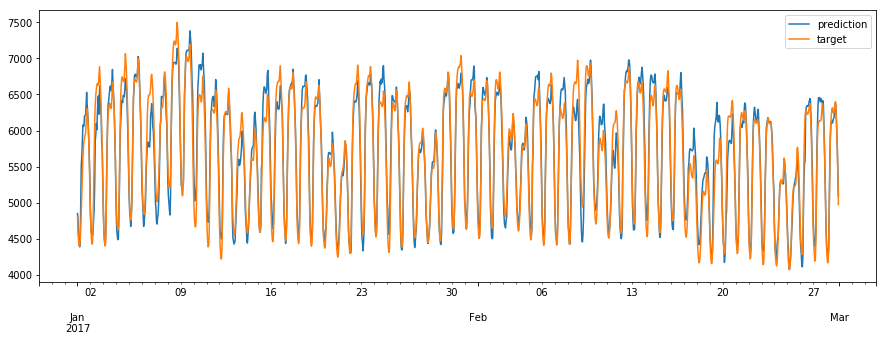

In [18]:
prediction_target_df.plot(figsize=(15,5))

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
mean_absolute_percentage_error(
    prediction_target_df['prediction'], 
    prediction_target_df['target'])

2.853458084624997

In [31]:
def predict(date, hour):
    """
    Takes in a date and hour value and predicts the load value 
    24 hours into the future. 
    
    Args:
        date: Tuple: The date as a tuple of form (YYYY, MM, DD)
        hour: Int: Value ranging between 0-23
        
    Returns:
        prediction: Float: The predicted load value 24 hours into the future.
    """
    date = datetime.datetime(*date, hour, 0)
    
    prediction = regr.predict(
        load_and_weather_data_all_final.loc[str(date)][features].values.reshape(1, -1))
    
    return float(prediction)

In [32]:
predict((2017,1,1), 0)

4849.563676227008